# Image viewer

In [1]:
%matplotlib widget
DEBUG = False

In [62]:
import os
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from glob import glob
from skimage.io import imread
from skimage.color import rgb2gray
from ipyfilechooser import FileChooser
import traceback
import functools
import fnmatch
from astropy.io import fits
from scipy.ndimage import median_filter

In [63]:
FILE_PATTERNS = ['*.png', '*.jpg', '*.npy', '*.fits']

# Set the filter pattern to only allow PNG and JPG files
folder_selector = FileChooser(
    os.path.realpath('.'),
    show_only_dirs=True,
    select_desc="Select folder",
    change_desc="Change folder",
)

folder_selector.layout = widgets.Layout(width='600px')  # Expand width of the folder selection
folder_selector._select.layout = widgets.Layout(width="200px")

file_selection_widget = widgets.Select(
    options=[],
    description="Files in folder:",
    style={'description_width': 'initial'},
    layout={'width': '400px'}
)
refresh_button = widgets.Button(description="Refresh file list", style={'description_width': 'initial'})
q99_button = widgets.Button(description="99%", style={'description_width': 'initial'})

normalize_to_max_checkbox = widgets.Checkbox(value=False, description='Normalize to max')
apply_median_filter_checkbox = widgets.Checkbox(value=False, description='Apply median 3x3 filter')

vmin_vmax_slider = widgets.FloatRangeSlider(value=[0, 1], min=0, max=1., step=0.001, description='Contrast:', layout=widgets.Layout(width=f'{7*72}px'))
logy_checkbox = widgets.Checkbox(value=False, description='Log y scale', layout=widgets.Layout(width=f'{3*72}px'))
x_range_slider = widgets.IntRangeSlider(value=[0, 1], min=0, max=1, step=1, description='X Range:', layout=widgets.Layout(width=f'{8.5*72}px'))
y_range_slider = widgets.IntRangeSlider(value=[0, 1], min=0, max=1, step=1, description='Y Range:', orientation='vertical', layout=widgets.Layout(height=f'{7*72}px'))
error_widget = widgets.HTML() #widgets.Label() #widgets.HTML()

#fig, axes = plt.subplots(2, 3, figsize=(12, 8), gridspec_kw={'width_ratios': [4, 1, 1], 'height_ratios': [4, 1]})
#ax_img, ax_hist, ax_right = axes[0]
#ax_bottom, _, _ = axes[1]

plt.ioff() # Avoid displaying automatically - will need to be re-enabled at the end
fig_contrast, ax_hist = plt.subplots(1, 1, figsize=(6.5, 0.5))
fig_contrast.subplots_adjust(left=0, right=1, top=1, bottom=0)

fig_colorbar, ax_colorbar = plt.subplots(1, 1, figsize=(6.5, 0.25))
fig_colorbar.subplots_adjust(left=0, right=1, top=1, bottom=0)

fig, axes = plt.subplots(2, 2, figsize=(6, 6), gridspec_kw={'width_ratios': [4, 1], 'height_ratios': [4, 1], })
ax_img, ax_right = axes[0]
ax_bottom, ax_empty = axes[1]
fig.subplots_adjust(left=0.1, right=1, top=1, bottom=0.05)

#ax_img.set_title("Image")
#ax_bottom.set_title("Integrated X")
#ax_right.set_title("Integrated Y")
ax_empty.clear()  # Remove any existing content
ax_empty.set_xticks([])  # Remove x-axis ticks
ax_empty.set_yticks([])  # Remove y-axis ticks
ax_empty.set_xticklabels([])  # Remove x-axis tick labels
ax_empty.set_yticklabels([])  # Remove y-axis tick labels
ax_empty.set_frame_on(False)  # Remove the frame

img = None
original_image = None

def filter_files(filenames, patterns):
    return [f for f in filenames if any(fnmatch.fnmatch(f, p) for p in patterns)]

def format_exception_html(exception):
    """Formats an exception as an HTML string with styling. UNSAFE!"""
    formatted_traceback = traceback.format_exc()
    return f"""
    <div style="color: red; font-family: monospace; white-space: pre-wrap;">
        <b>Error:</b> {str(exception)}<br>
        <pre>{formatted_traceback}</pre>
    </div>
    """

def catch_errors(widget):
    def decorator(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            widget.value = ""
            try:
                return func(*args, **kwargs)
            except Exception as e:
                #error_message = f'```Error: SOME ERROR\nLine 1\n\nLine 2\n\n Line 3\n\n```\n</span>'
                #error_message = f'```\nError: {str(e)}\n{traceback.format_exc()}\n```\n</span>'
                #html = markdown.markdown(error_message)
                #widget.value = f'<span style="color: #ff0000;">{html}</span>'  # Update the widget with the error message
                widget.value = format_exception_html(e)
        return wrapper
    return decorator

def update_files_in_folder(change=None):
    folder = folder_selector.selected
    files = os.listdir(folder)
    # Only files matching, and sort alphabetically
    filtered_files = sorted(filter_files(files, FILE_PATTERNS))

    # Update widget
    file_selection_widget.options = filtered_files
    if filtered_files:
        # Select the first file
        file_selection_widget.value = file_selection_widget.options[0]

def update_hist_yscale(change=None):
    global ax_hist, ax_colorbar, logy_checkbox

    for ax in [ax_colorbar, ax_hist]:
        if logy_checkbox.value:
            ax.set_yscale('log')
            ax.relim() # recompute the data limits
            ax.autoscale(axis='y') 
            ax.set_ylim(0.1, None)
        else:
            ax.set_yscale('linear')
            ax.relim() # recompute the data limits
            ax.autoscale(axis='y') 
            ax.set_ylim(0, None)
        

@catch_errors(error_widget)
def reload_image(change=None):
    global img
    global original_image
    
    folder = folder_selector.selected
    # If both are not None
    if folder and file_selection_widget.value:
        file_path = os.path.join(folder, file_selection_widget.value)
    else:
        file_path = None
    # Returns if nothing is selected (but first clear all)
    if not file_path or not os.path.exists(file_path):
        ax_hist.clear()
        ax_colorbar.clear()
        ax_img.clear()
        ax_right.clear()
        ax_bottom.clear()
        return
    
    # Load and preprocess image
    if file_path.endswith('.npy'):
        img = np.load(file_path)
        # Image needs to be flipped upside-down
        img = np.flipud(img)
    elif file_path.endswith('.fits'):
        with fits.open(file_path) as hdul:
            hdu = hdul[0]
            img = hdu.data.copy()
    else:
        img = imread(file_path)
        # Image needs to be flipped upside-down
        img = np.flipud(img)
    
    if len(img.shape) == 3 and img.shape[2] == 4: # RGBA, convert to RGB on white background
        alpha_channel = img[:,:,3]
        rgb_channels = img[:,:,:3]

        # White Background Image
        white_background_image = np.ones_like(rgb_channels, dtype=np.uint8) * 255

        # Alpha factor
        alpha_factor = alpha_channel[:,:,np.newaxis].astype(np.float32) / 255
        alpha_factor = np.concatenate((alpha_factor,alpha_factor,alpha_factor), axis=2)
        
        # Transparent Image Rendered on White Background
        base = rgb_channels.astype(np.float32) * alpha_factor
        white = white_background_image.astype(np.float32) * (1 - alpha_factor)
        final_image = base + white
        original_image = img
        img = final_image.astype(np.uint8)
        #img = rgb_channels

    # Convert to RGB
    if len(img.shape) == 3:
        img = rgb2gray(img)    

    if DEBUG:
        error_widget.value = f"BEFORE: {img.dtype=}, {img.min()=}, {img.max()=}<br>"
    if img.dtype in (np.uint8, np.uint16):
        img = img.astype(float) / np.iinfo(img.dtype).max    
    if apply_median_filter_checkbox.value:
        img = median_filter(img, size=3)
#        if DEBUG:
#            error_widget.value += f"AFTER FILTER: {img.dtype=}, {img.min()=}, {img.max()=}<br>"
    if normalize_to_max_checkbox.value:
        img /= img.max()
    if DEBUG:
        error_widget.value += f"AFTER: {img.dtype=}, {img.min()=}, {img.max()=}<br>"

    # Update sliders based on image dimensions
    x_range_slider.min, x_range_slider.max = 0, img.shape[1]
    y_range_slider.min, y_range_slider.max = 0, img.shape[0]
    x_range_slider.value = 0, img.shape[1]
    y_range_slider.value = 0, img.shape[0]

    update_image(change=change)

def update_image(change=None):
    global img, ax_img, ax_hist, ax_bottom, ax_right

    # Update histogram
    hist, bins = np.histogram(img.flatten(), bins=256, range=(0, 1))
    for ax in [ax_colorbar, ax_hist]:
        ax.clear()
        ax.plot((bins[:-1] + bins[1:])/2, hist, color='black')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        update_hist_yscale() # Calling it again as it is reset

    # x range
    ax_hist.set_xlim(0, 1)
    vmin, vmax = vmin_vmax_slider.value

    for ax in [ax_colorbar, ax_hist]:
        y_min, y_max = ax.get_ylim()
        gradient = np.linspace(0, 1, 256).reshape(1, -1)  # Horizontal gradient
        ax.imshow(gradient, extent=[vmin, vmax, y_min, y_max], aspect='auto', cmap='gray', alpha=0.5)

    ax_colorbar.set_xlim(vmin, vmax)
    ax_hist.axvline(vmin, color='red', linestyle='--')
    ax_hist.axvline(vmax, color='blue', linestyle='--')
    
    # Update image display
    ax_img.clear()    
    ax_img.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    ax_img.set_xlim(0, img.shape[1])
    ax_img.set_ylim(0, img.shape[0])
    ax_img.set_xticklabels([])
    ax_img.set_yticklabels([])
    ax_img.set_xticks([])
    ax_img.set_yticks([])

    
    # Update crop lines
    x1, x2 = x_range_slider.value
    y1, y2 = y_range_slider.value
    ax_img.axvline(x1, color='red', linestyle='--')
    ax_img.axvline(x2, color='red', linestyle='--')
    ax_img.axhline(y1, color='blue', linestyle='--')
    ax_img.axhline(y2, color='blue', linestyle='--')
    
    # Extract cropped region and update projections
    cropped = img[int(y1):int(y2), int(x1):int(x2)]
    
    ax_bottom.clear()
    ax_bottom.plot(np.mean(cropped, axis=0))
    ax_bottom.set_xlim(0, cropped.shape[1])
    
    ax_right.clear()
    ax_right.plot(np.mean(cropped, axis=1), np.arange(len(np.mean(cropped, axis=1))))
    ax_right.set_ylim(0, cropped.shape[0])


def qunatile_histogram(data, q=0.95, bins=100) :
    lower = (1 - q) / 2
    upper = 1 - lower
    low_val, high_val = np.quantile(data, [lower, upper])

    # Filter data within quantile range
    filtered_data = data[(data >= low_val) & (data <= high_val)]

    # Create histogram
    hist, bin_edges = np.histogram(filtered_data, bins=256)
    
    return history,bin_edges

def set_quantile_interval(change=None):
    q=0.99
    
    lower = (1 - q) / 2
    upper = 1 - lower
    
    low_val, high_val = np.quantile(img.ravel(), [lower, upper])
    print(low_val,high_val)
    vmin_vmax_slider.value=(low_val,high_val)
    
# Link events
folder_selector.register_callback(update_files_in_folder)
file_selection_widget.observe(reload_image, names='value')
vmin_vmax_slider.observe(update_image, names='value')
x_range_slider.observe(update_image, names='value')
y_range_slider.observe(update_image, names='value')
refresh_button.on_click(update_files_in_folder)
q99_button.on_click(set_quantile_interval)
logy_checkbox.observe(update_hist_yscale, names='value')
apply_median_filter_checkbox.observe(reload_image, names='value')
normalize_to_max_checkbox.observe(reload_image, names='value')

display(widgets.VBox([folder_selector,
                      widgets.HBox([file_selection_widget, refresh_button]),
                      error_widget,
                      widgets.HBox([normalize_to_max_checkbox, apply_median_filter_checkbox]),
                      fig_contrast.canvas,
                      widgets.HBox([q99_button,logy_checkbox, vmin_vmax_slider]), 
                      fig_colorbar.canvas,
                      widgets.HBox([y_range_slider,fig.canvas]),
                      x_range_slider, 
                      ]))

# Reactivate interactivity now that everything is displayed
plt.ion()
# Initialize with first image
reload_image()

In [3]:
file_selection_widget.value

In [9]:
import re
def make_file_mask(filename) :
    match = re.search(r'_(0*\d+)(\.fits)$', filename)
    if match:
        original_number = match.group(1)  # Extract the original number with padding
        num_digits = len(original_number)  # Determine the length of the original padding
        return re.sub(r'_(0*\d+)(\.fits)$', f'_{{0:0{num_digits}d}}\\2', filename)
    return filename  # Return unchanged if no match found

In [10]:
names = ['cal_00001.fits','var_cal_0001.fits','c_v_cal_01.fits','cal_1.fits']
for name in names : 
    print(name,make_file_mask(name))

cal_00001.fits cal_{0:05d}.fits
var_cal_0001.fits var_cal_{0:04d}.fits
c_v_cal_01.fits c_v_cal_{0:02d}.fits
cal_1.fits cal_{0:01d}.fits


In [11]:
import os

def list_matching_files(directory, pattern="file_*.ext"):
    return sorted(glob(f"{directory}/{pattern}"))

def find_first_last_indices(filenames, pattern=r'mask_(\d{4})\.fits'):
    indices = []

    
    for filename in filenames:
        filename = filename.split('/')[-1]
        match=re.search(r'_(0*\d+)(\.fits)$', filename)
        if match:
            indices.append(int(match.group(1)))  # Convert to integer

    if indices:
        return min(indices), max(indices)
    else:
        return None, None  # If no matches found

In [12]:
flist=list_matching_files('/Users/Shared/Data/P20240876/02_rawdata/04_Straw_NR_TR_yes_T27_R1/',r'*.fits')

In [13]:
find_first_last_indices(flist,'cal_{0:05d}.fits')

(1, 125)

# Image browser

In [61]:
import os
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from glob import glob
from skimage.io import imread
from skimage.color import rgb2gray
from ipyfilechooser import FileChooser
import traceback
import functools
import fnmatch
from astropy.io import fits
from scipy.ndimage import median_filter
import importlib

FILE_PATTERNS = ['*.png', '*.jpg', '*.npy', '*.fits']

# Set the filter pattern to only allow PNG and JPG files
folder_selector = FileChooser(
    os.path.realpath('.'),
    show_only_dirs=True,
    select_desc="Select folder",
    change_desc="Change folder",
)

folder_selector.layout = widgets.Layout(width='600px')  # Expand width of the folder selection
folder_selector._select.layout = widgets.Layout(width="200px")

file_selection_widget = widgets.Select(
    options=[],
    description="Files in folder:",
    style={'description_width': 'initial'},
    layout={'width': '400px'}
)
refresh_button = widgets.Button(description="Refresh file list", style={'description_width': 'initial'})
q99_button = widgets.Button(description="99%", style={'description_width': 'initial'})

normalize_to_max_checkbox = widgets.Checkbox(value=False, description='Normalize to max')
apply_median_filter_checkbox = widgets.Checkbox(value=False, description='Apply median 3x3 filter')

vmin_vmax_slider = widgets.FloatRangeSlider(value=[0, 1], min=0, max=1., step=0.001, description='Contrast:', layout=widgets.Layout(width=f'{7*72}px'))
# logy_checkbox = widgets.Checkbox(value=False, description='Log y scale', layout=widgets.Layout(width=f'{3*72}px'))
# x_range_slider = widgets.IntRangeSlider(value=[0, 1], min=0, max=1, step=1, description='X Range:', layout=widgets.Layout(width=f'{8.5*72}px'))
# y_range_slider = widgets.IntRangeSlider(value=[0, 1], min=0, max=1, step=1, description='Y Range:', orientation='vertical', layout=widgets.Layout(height=f'{7*72}px'))
error_widget = widgets.HTML() #widgets.Label() #widgets.HTML()


plt.ioff() # Avoid displaying automatically - will need to be re-enabled at the end
fig_contrast, ax_hist = plt.subplots(1, 1, figsize=(6.5, 0.5))
fig_contrast.subplots_adjust(left=0, right=1, top=1, bottom=0)

# fig_colorbar, ax_colorbar = plt.subplots(1, 1, figsize=(6.5, 0.25))
# fig_colorbar.subplots_adjust(left=0, right=1, top=1, bottom=0)

fig, axes = plt.subplots(2, 2, figsize=(6, 6), gridspec_kw={'width_ratios': [4, 1], 'height_ratios': [4, 1], })
ax_img, ax_right = axes[0]
ax_bottom, ax_empty = axes[1]
fig.subplots_adjust(left=0.1, right=1, top=1, bottom=0.05)

#ax_img.set_title("Image")
#ax_bottom.set_title("Integrated X")
#ax_right.set_title("Integrated Y")
ax_empty.clear()  # Remove any existing content
ax_empty.set_xticks([])  # Remove x-axis ticks
ax_empty.set_yticks([])  # Remove y-axis ticks
ax_empty.set_xticklabels([])  # Remove x-axis tick labels
ax_empty.set_yticklabels([])  # Remove y-axis tick labels
ax_empty.set_frame_on(False)  # Remove the frame

img = None
original_image = None

def filter_files(filenames, patterns):
    return [f for f in filenames if any(fnmatch.fnmatch(f, p) for p in patterns)]

def format_exception_html(exception):
    """Formats an exception as an HTML string with styling. UNSAFE!"""
    formatted_traceback = traceback.format_exc()
    return f"""
    <div style="color: red; font-family: monospace; white-space: pre-wrap;">
        <b>Error:</b> {str(exception)}<br>
        <pre>{formatted_traceback}</pre>
    </div>
    """

def catch_errors(widget):
    def decorator(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            widget.value = ""
            try:
                return func(*args, **kwargs)
            except Exception as e:
                #error_message = f'```Error: SOME ERROR\nLine 1\n\nLine 2\n\n Line 3\n\n```\n</span>'
                #error_message = f'```\nError: {str(e)}\n{traceback.format_exc()}\n```\n</span>'
                #html = markdown.markdown(error_message)
                #widget.value = f'<span style="color: #ff0000;">{html}</span>'  # Update the widget with the error message
                widget.value = format_exception_html(e)
        return wrapper
    return decorator

def update_files_in_folder(change=None):
    folder = folder_selector.selected
    files = os.listdir(folder)
    # Only files matching, and sort alphabetically
    filtered_files = sorted(filter_files(files, FILE_PATTERNS))

    # Update widget
    file_selection_widget.options = filtered_files
    if filtered_files:
        # Select the first file
        file_selection_widget.value = file_selection_widget.options[0]

def update_hist_yscale(change=None):
    global ax_hist, ax_colorbar, logy_checkbox

    for ax in [ax_colorbar, ax_hist]:
        if logy_checkbox.value:
            ax.set_yscale('log')
            ax.relim() # recompute the data limits
            ax.autoscale(axis='y') 
            ax.set_ylim(0.1, None)
        else:
            ax.set_yscale('linear')
            ax.relim() # recompute the data limits
            ax.autoscale(axis='y') 
            ax.set_ylim(0, None)
        

@catch_errors(error_widget)
def reload_image(change=None):
    global img
    global original_image
    
    folder = folder_selector.selected
    # If both are not None
    if folder and file_selection_widget.value:
        file_path = os.path.join(folder, file_selection_widget.value)
    else:
        file_path = None
    # Returns if nothing is selected (but first clear all)
    if not file_path or not os.path.exists(file_path):
        ax_hist.clear()
        ax_colorbar.clear()
        ax_img.clear()
        ax_right.clear()
        ax_bottom.clear()
        return
    
    # Load and preprocess image
    if file_path.endswith('.npy'):
        img = np.load(file_path)
        # Image needs to be flipped upside-down
        img = np.flipud(img)
    elif file_path.endswith('.fits'):
        with fits.open(file_path) as hdul:
            hdu = hdul[0]
            img = hdu.data.copy()
    else:
        img = imread(file_path)
        # Image needs to be flipped upside-down
        img = np.flipud(img)
    
    if len(img.shape) == 3 and img.shape[2] == 4: # RGBA, convert to RGB on white background
        alpha_channel = img[:,:,3]
        rgb_channels = img[:,:,:3]

        # White Background Image
        white_background_image = np.ones_like(rgb_channels, dtype=np.uint8) * 255

        # Alpha factor
        alpha_factor = alpha_channel[:,:,np.newaxis].astype(np.float32) / 255
        alpha_factor = np.concatenate((alpha_factor,alpha_factor,alpha_factor), axis=2)
        
        # Transparent Image Rendered on White Background
        base = rgb_channels.astype(np.float32) * alpha_factor
        white = white_background_image.astype(np.float32) * (1 - alpha_factor)
        final_image = base + white
        original_image = img
        img = final_image.astype(np.uint8)
        #img = rgb_channels

    # Convert to RGB
    if len(img.shape) == 3:
        img = rgb2gray(img)    

    if DEBUG:
        error_widget.value = f"BEFORE: {img.dtype=}, {img.min()=}, {img.max()=}<br>"
    if img.dtype in (np.uint8, np.uint16):
        img = img.astype(float) / np.iinfo(img.dtype).max    
    if apply_median_filter_checkbox.value:
        img = median_filter(img, size=3)
#        if DEBUG:
#            error_widget.value += f"AFTER FILTER: {img.dtype=}, {img.min()=}, {img.max()=}<br>"
    if normalize_to_max_checkbox.value:
        img /= img.max()
    if DEBUG:
        error_widget.value += f"AFTER: {img.dtype=}, {img.min()=}, {img.max()=}<br>"

    # Update sliders based on image dimensions
    x_range_slider.min, x_range_slider.max = 0, img.shape[1]
    y_range_slider.min, y_range_slider.max = 0, img.shape[0]
    x_range_slider.value = 0, img.shape[1]
    y_range_slider.value = 0, img.shape[0]

    update_image(change=change)

def update_image(change=None):
    global img, ax_img, ax_hist, ax_bottom, ax_right

    # Update histogram
    hist, bins = np.histogram(img.flatten(), bins=256, range=(0, 1))
    for ax in [ax_colorbar, ax_hist]:
        ax.clear()
        ax.plot((bins[:-1] + bins[1:])/2, hist, color='black')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        update_hist_yscale() # Calling it again as it is reset

    # x range
    ax_hist.set_xlim(0, 1)
    vmin, vmax = vmin_vmax_slider.value

    for ax in [ax_colorbar, ax_hist]:
        y_min, y_max = ax.get_ylim()
        gradient = np.linspace(0, 1, 256).reshape(1, -1)  # Horizontal gradient
        ax.imshow(gradient, extent=[vmin, vmax, y_min, y_max], aspect='auto', cmap='gray', alpha=0.5)

    ax_colorbar.set_xlim(vmin, vmax)
    ax_hist.axvline(vmin, color='red', linestyle='--')
    ax_hist.axvline(vmax, color='blue', linestyle='--')
    
    # Update image display
    ax_img.clear()    
    ax_img.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    ax_img.set_xlim(0, img.shape[1])
    ax_img.set_ylim(0, img.shape[0])
    ax_img.set_xticklabels([])
    ax_img.set_yticklabels([])
    ax_img.set_xticks([])
    ax_img.set_yticks([])

    
    # Update crop lines
    x1, x2 = x_range_slider.value
    y1, y2 = y_range_slider.value
    ax_img.axvline(x1, color='red', linestyle='--')
    ax_img.axvline(x2, color='red', linestyle='--')
    ax_img.axhline(y1, color='blue', linestyle='--')
    ax_img.axhline(y2, color='blue', linestyle='--')
    
    # Extract cropped region and update projections
    cropped = img[int(y1):int(y2), int(x1):int(x2)]
    
    ax_bottom.clear()
    ax_bottom.plot(np.mean(cropped, axis=0))
    ax_bottom.set_xlim(0, cropped.shape[1])
    
    ax_right.clear()
    ax_right.plot(np.mean(cropped, axis=1), np.arange(len(np.mean(cropped, axis=1))))
    ax_right.set_ylim(0, cropped.shape[0])

def set_quantile_interval(change=None):
    q=0.99
    rq2=(1-q)/2.0
    
    hist, bins = np.histogram(img.flatten(), bins=256, range=(0, 1))
    chist = np.cumsum(hist)
    chist = chist/chist.max()
    
    start_idx = np.searchsorted(chist, rq2, side='left')
    end_idx = np.searchsorted(chist, q+rq2, side='right')
    
    vmin_vmax_slider.value=(bins[start_idx],bins[end_idx])
# Link events
folder_selector.register_callback(update_files_in_folder)
file_selection_widget.observe(reload_image, names='value')
vmin_vmax_slider.observe(update_image, names='value')
x_range_slider.observe(update_image, names='value')
y_range_slider.observe(update_image, names='value')
refresh_button.on_click(update_files_in_folder)
q99_button.on_click(set_quantile_interval)
logy_checkbox.observe(update_hist_yscale, names='value')
apply_median_filter_checkbox.observe(reload_image, names='value')
normalize_to_max_checkbox.observe(reload_image, names='value')

display(widgets.VBox([folder_selector,
                      widgets.HBox([file_selection_widget, refresh_button]),
                      error_widget,
                      widgets.HBox([normalize_to_max_checkbox, apply_median_filter_checkbox]),
                      fig_contrast.canvas,
                      widgets.HBox([q99_button,logy_checkbox, vmin_vmax_slider]), 
                      fig_colorbar.canvas,
                      widgets.HBox([y_range_slider,fig.canvas]),
                      x_range_slider, 
                      ]))

# Reactivate interactivity now that everything is displayed
plt.ion()
# Initialize with first image
reload_image()

# File selection widget

In [15]:
FILE_PATTERNS = ['*.png', '*.jpg', '*.npy', '*.fits']

# Set the filter pattern to only allow PNG and JPG files
folder_selector = FileChooser(
    os.path.realpath('.'),
    show_only_dirs=False,
    select_desc="Browse file",
    change_desc="Change file",
)

folder_selector.layout = widgets.Layout(width='800px')  # Expand width of the folder selection
folder_selector._select.layout = widgets.Layout(width="200px")

In [16]:
display(folder_selector)

FileChooser(path='/Users/kaestner/git/scripts/python/imagingUI', filename='', title='', show_hidden=False, sel…

In [17]:
folder_selector.selected

'/Users/Shared/Data/P20240876/02_rawdata/04_Straw_NR_TR_yes_T27_R1/TS_00065.fits'

# File mask extractor

In [36]:
import os
from ipyfilechooser import FileChooser
import ipywidgets as widgets
import sys
sys.path.append('../')
import amglib.readers as rd

class FileSelector:
    FILE_PATTERNS = ['*.png', '*.jpg', '*.npy', '*.fits', '*.tif', '*.tiff']
    
    @property
    def file_name(self) :
        return self._fileinfo["name"]
    
    @property 
    def file_path(self) :
        return self._fileinfo["path"]
    
    @property 
    def file_mask(self) :
        return self._fileinfo["mask"]
    
    @property 
    def first_index(self) :
        return self._fileinfo["first"]
    
    @property
    def last_index(self) :
        return self._fileinfo["last"]
    
    @property
    def info(self) :
        return self._fileinfo

    def __init__(self, start_dir='.'):
        self.file_chooser = FileChooser(
            os.path.realpath(start_dir),
            show_only_dirs=False,
            select_desc="Browse file",
            change_desc="Change file",
#             filter_pattern=";".join(self.FILE_PATTERNS)
        )
        self.file_chooser.layout = widgets.Layout(width='800px')
        self.file_chooser._select.layout = widgets.Layout(width="200px")
        self.file_chooser.register_callback(self.on_file_selected)

    def on_file_selected(self, chooser):
        selected = chooser.selected
        if selected:
            self.analyze_file(selected)

    def analyze_file(self, filename):
        # Implement your analysis logic here
        fname      = self.file_chooser.selected
        path       = os.path.dirname(fname)
        ext        = fname.split('.')[-1]
        flist      = list_matching_files(path,r'_'.join(fname.split('/')[-1].split('_')[:-1])+'*.'+ext)
        fmask      = rd.make_file_mask(fname)
        first,last = rd.find_first_last_indices(flist,fmask.split('/')[-1])

        self._fileinfo = { "name" : fname,
                           "mask" : fmask,
                           "path" : path,
                           "ext"  : ext,
                           "first": first,
                           "last" : last,
                           "files": flist}

    def display(self):
        display(self.file_chooser)

# Usage:
analyzer = FileSelector()
analyzer.display()

FileChooser(path='/Users/kaestner/git/scripts/python/imagingUI', filename='', title='', show_hidden=False, sel…

# File selector widget

In [5]:
import sys
sys.path.append('../')
import amglib.widgets as aw
import importlib

importlib.reload(aw)
fs = aw.FileSelector()
fs.display()

FileChooser(path='/Users/kaestner/git/scripts/python/imagingUI', filename='', title='', show_hidden=False, sel…

In [6]:
fs.info

{'name': '/Users/Shared/Data/Budha/ngl-1/Tomo data/Bottom part/Capture_00002.tif',
 'mask': '/Users/Shared/Data/Budha/ngl-1/Tomo data/Bottom part/Capture_{0:05d}.tif',
 'path': '/Users/Shared/Data/Budha/ngl-1/Tomo data/Bottom part',
 'ext': 'tif',
 'first': 2,
 'last': 527,
 'files': ['/Users/Shared/Data/Budha/ngl-1/Tomo data/Bottom part/Capture_00002.tif',
  '/Users/Shared/Data/Budha/ngl-1/Tomo data/Bottom part/Capture_00003.tif',
  '/Users/Shared/Data/Budha/ngl-1/Tomo data/Bottom part/Capture_00004.tif',
  '/Users/Shared/Data/Budha/ngl-1/Tomo data/Bottom part/Capture_00005.tif',
  '/Users/Shared/Data/Budha/ngl-1/Tomo data/Bottom part/Capture_00006.tif',
  '/Users/Shared/Data/Budha/ngl-1/Tomo data/Bottom part/Capture_00007.tif',
  '/Users/Shared/Data/Budha/ngl-1/Tomo data/Bottom part/Capture_00008.tif',
  '/Users/Shared/Data/Budha/ngl-1/Tomo data/Bottom part/Capture_00009.tif',
  '/Users/Shared/Data/Budha/ngl-1/Tomo data/Bottom part/Capture_00010.tif',
  '/Users/Shared/Data/Budha/ngl-

# ROI selector

## Basic example

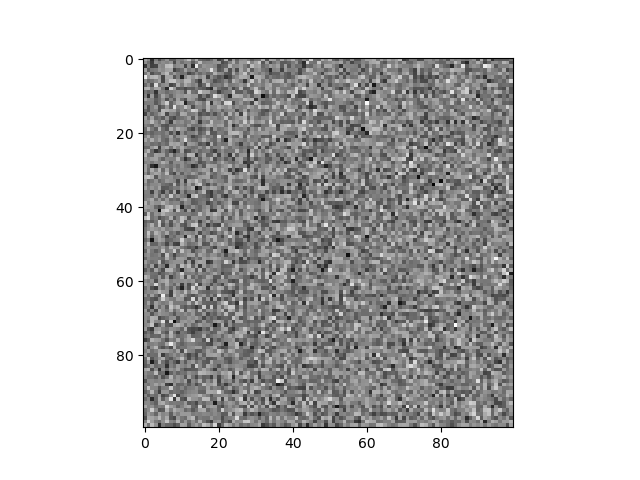

In [42]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import numpy as np

# Sample image
image = np.random.normal(0,1,size=(100, 100))

fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')

roi = {}

def onselect(eclick, erelease):
    x1, y1 = int(eclick.xdata), int(eclick.ydata)
    x2, y2 = int(erelease.xdata), int(erelease.ydata)
    roi['x1'], roi['y1'] = min(x1, x2), min(y1, y2)
    roi['x2'], roi['y2'] = max(x1, x2), max(y1, y2)
    print("ROI selected:", roi)

selector = RectangleSelector(
    ax, onselect,
    useblit=True,
    button=[1],
    minspanx=5, minspany=5,
    spancoords='pixels',
    interactive=True
)

plt.show()



In [54]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import numpy as np

class ROISelector:
    def __init__(self, image: np.ndarray, cmap='viridis', title=None, show_colorbar=False, quantile=None):
        self._image = image
        self._roi_coords = None

        self._fig, self._ax = plt.subplots()
        if quantile is not None :
            vmin = np.quantile(self._image, (1-quantile)/2)
            vmax = np.quantile(self._image, 0.5+quantile/2)
        else:
            vmin = self._image.min()
            vmax = self._image.max()
            
        a = self._ax.imshow(self._image, cmap=cmap,vmin=vmin,vmax=vmax)
        
        if show_colorbar :
            self._fig.colorbar(a)
            
        self._selector = RectangleSelector(
            self._ax,
            self._on_select,
            useblit=True,
            button=[1],  # Left mouse button
            minspanx=2,
            minspany=2,
            spancoords='pixels',
            interactive=True
        )
        self._fig.canvas.header_visible = False
        self._fig.canvas.footer_visible = False
        self._fig.canvas.toolbar_visible = False
        plt.show()

    def _on_select(self, eclick, erelease):
        x1, y1 = int(eclick.xdata), int(eclick.ydata)
        x2, y2 = int(erelease.xdata), int(erelease.ydata)
        self._roi_coords = (min(x1, x2), min(y1, y2), max(x1, x2), max(y1, y2))
        print("ROI selected:", self._roi_coords)
        
    def __del__(self):
        # Safely close the figure when object is deleted
        if hasattr(self, "_fig"):
            plt.close(self._fig)
            # Optional: print for debugging
            print("ROISelector figure closed.")

    @property
    def roi(self):
        """Return the selected ROI as (x1, y1, x2, y2) or None if not yet selected."""
        return self._roi_coords

    @property
    def roi_image(self):
        """Return the extracted ROI image (as a NumPy array) or None if not yet selected."""
        if self._roi_coords is None:
            return None
        x1, y1, x2, y2 = self._roi_coords
        return self._image[y1:y2, x1:x2]


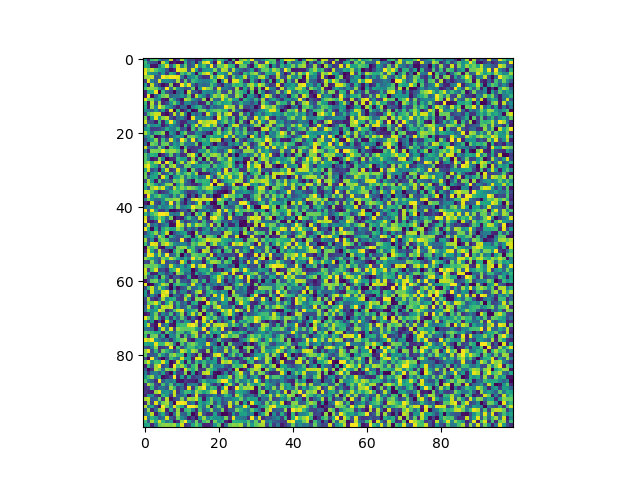

In [58]:
# Sample image
image = np.random.rand(100, 100)

# Create selector instance
selector = ROISelector(image)

# After selecting ROI, you can get:
# selector.roi → (x1, y1, x2, y2)
# selector.roi_image → numpy subimage


In [72]:
selector.roi

(53, 42, 81, 69)

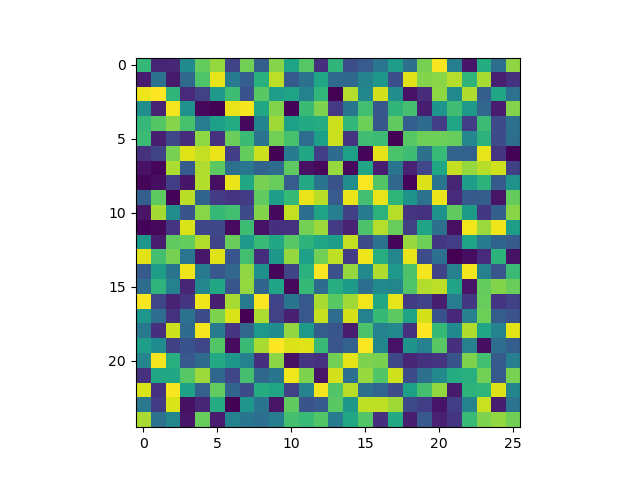

In [60]:
plt.figure()
plt.imshow(selector.roi_image)

In [39]:
q = np.quantile(image, 0.10)
q

np.float64(0.10106482633720158)

In [32]:
q

np.float64(0.9012668347170896)

(array([113.,  98., 105., 112., 106., 110.,  90., 107., 111., 115.,  95.,
        110.,  91., 126., 111.,  82.,  83.,  92., 113., 112.,  97., 123.,
         99.,  77., 101., 111., 100.,  85.,  84.,  96.,  92., 125.,  87.,
         84., 117., 106., 102.,  96.,  88., 105., 114.,  89., 118.,  92.,
         98.,  85., 119.,  90.,  91.,  99.,  88., 104.,  94.,  94.,  93.,
         95., 116.,  87., 110.,  95.,  92.,  96.,  96., 104.,  88.,  97.,
        114.,  94.,  94.,  84.,  99., 103., 123., 104., 100.,  98.,  98.,
         92.,  94.,  90., 110., 117.,  98., 104.,  99., 111.,  89.,  88.,
         87.,  97., 115., 108., 105.,  92., 100.,  78., 104.,  88., 106.,
        116.]),
 array([5.44924876e-05, 1.00538802e-02, 2.00532680e-02, 3.00526557e-02,
        4.00520435e-02, 5.00514312e-02, 6.00508190e-02, 7.00502067e-02,
        8.00495944e-02, 9.00489822e-02, 1.00048370e-01, 1.10047758e-01,
        1.20047145e-01, 1.30046533e-01, 1.40045921e-01, 1.50045309e-01,
        1.60044696e-01, 1.7004

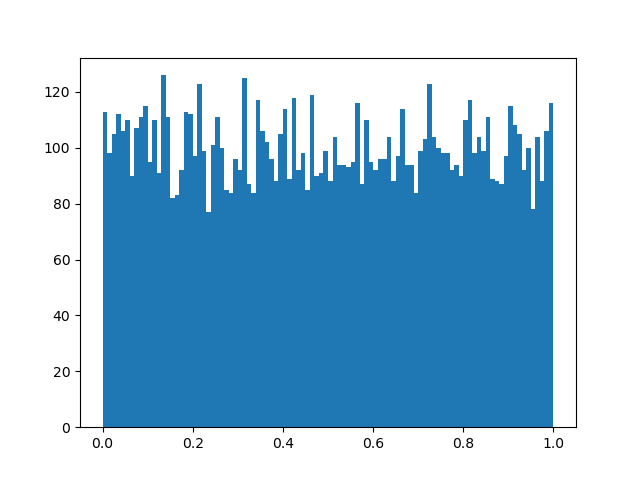

In [57]:
plt.figure()
plt.hist(image.ravel(),bins=100)

### Try roi from lib

In [69]:
import amglib.widgets as aw
importlib.reload(aw)

<module 'amglib.widgets' from '/Users/kaestner/git/scripts/python/imagingUI/../amglib/widgets.py'>

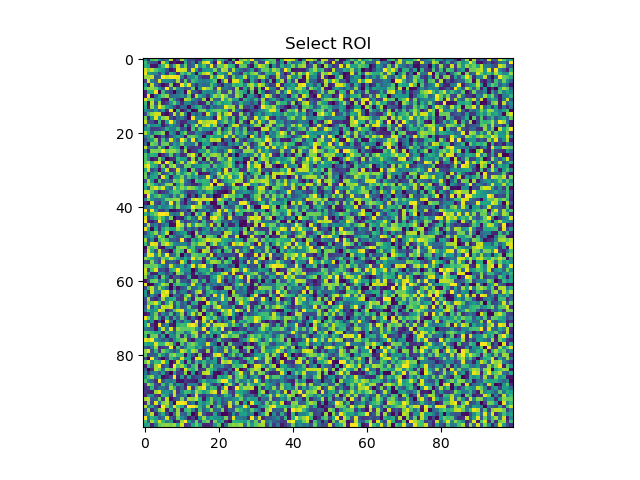

In [70]:
roisel = aw.ROISelector(image,title="Select ROI")

In [71]:
print(roisel.roi)

(28, 22, 74, 65)
